# Сборный проект №1. Анализ продаж интернет-магазина «Стримчик»


**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Описание данных**

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 100)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.stats as st
from math import factorial
import re
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Откройте файл с данными и изучите общую информацию

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В некоторых столбцах есть пропуски, нужно изменить названия всех столбцов (привести к нижнему регистру), столбец Year_of_Release перевести в формат integer, так как в нем хранится год выпуска игры, а год, как правило, записывается целым числом. 

В столбце User_Score нужно умножить значения на 10, для того чтобы оценки пользователей и критиков были в одном формате. Предварительно нужно поменять тип данных этого столбца на float, чтобы можно было применить умножение. Затем поменять тип данных столбцов Critic_Score и User_Score на integer, так как там все значения будут целые, но в формате float.

## Подготовьте данные

- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
- Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
- Опишите причины, которые могли привести к пропускам;
- Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

### Форматирование названий столбцов

In [4]:
data.columns = [
    'name', 'platform', 'year_of_release',
    'genre', 'na_sales', 'eu_sales',
    'jp_sales', 'other_sales', 'critic_score',
    'user_score', 'rating']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Столбец name

In [6]:
data = data.dropna(subset=['name'])
print ('Пропусков в столбце:', data['name'].isna().sum())

Пропусков в столбце: 0


В столбце было всего 2 пропуска. Заполнить их мы не можем, поэтому просто удалим эти пропуски.

### Столбец year_of_release

In [7]:
print ('Пропусков в столбце:', data['year_of_release'].isna().sum())
data.query('year_of_release.isna() == True')

Пропусков в столбце: 269


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Всего в столбце 269 пропусков. В некоторых названиях игр с пропущеным значением есть год. Перенесем его в столбец с годом выпуска.

In [8]:
# Создадим функцию для выделения года из названия игры
def extract_year_from_name(name):
    year_match = re.search(r"\b\d{4}\b", name)
    if year_match:
        return year_match.group()
    else:
        return np.nan

# Применяем функцию к столбцу name и создаем новый столбец с годами из столбца name
data['year_from_name'] = data.apply(lambda row: extract_year_from_name(row['name']), axis=1)

# Заполняем пропуски столбца year_of_release значениями из year_from_name
data['year_of_release'].fillna(data['year_from_name'], inplace=True)

data.pop('year_from_name')
print ('Пропусков в столбце:', data['year_of_release'].isna().sum())

Пропусков в столбце: 252


Игры могли выходить на разных платформах, если на одной из платформ указан год выпуска - используем его для заполнения пропуска этой же игры на других платформах.

In [9]:
grouped = data.groupby('name')['year_of_release']
data['year_of_release'].fillna(grouped.transform(lambda x: x.ffill().bfill()), inplace=True)
print (data['year_of_release'].dtype)
print ('Пропусков в столбце:', data['year_of_release'].isna().sum())

object
Пропусков в столбце: 139


In [10]:
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = pd.to_numeric(data['year_of_release'], downcast='integer', errors='ignore')
data['year_of_release'] = data['year_of_release'].replace(0, np.nan)


In [11]:
print (data['year_of_release'].dtype)
print ('Пропусков в столбце:', data['year_of_release'].isna().sum())

float64
Пропусков в столбце: 139


Заполнили 130 пропусков. С остальными пропусками в этом столбце ничего сделать не можем, оставим как есть.

### Столбец genre

In [12]:
data['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Пропуски в этом столбце удалились вместе с пропусками в 'name'. С названиями жанров все в порядке, дубликатов нет.

### Столбец user_score

In [13]:
print ('Пропусков в столбце:', data['user_score'].isna().sum())
print (data['user_score'].value_counts())
data['user_score'].describe()

Пропусков в столбце: 6699
tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.3       2
0.7       2
1.3       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64


count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

В столбце 6699 пропусков. Вместо 2424 оценок стоит значение 'tbd' (To Be Determined, то есть "Будет определено"). Заменим эти значения на NaN и обработаем вместе с остальными пропусками.

In [14]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = pd.to_numeric(data['user_score'])
print ('Пропусков в столбце:', data['user_score'].isna().sum())
print (data['user_score'].value_counts())

Пропусков в столбце: 9123
7.8    324
8.0    290
8.2    282
8.3    254
8.5    253
      ... 
0.9      2
1.9      2
1.3      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64


In [15]:
data['user_score'] = pd.to_numeric(data['user_score'])
data['user_score'] *= 10
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [16]:
data.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
year_of_release,1.000000,-0.092769,0.003944,-0.168260,0.037635,0.011567,-0.265377
na_sales,-0.092769,1.000000,0.765341,0.449668,0.638695,0.240755,0.086200
eu_sales,0.003944,0.765341,1.000000,0.435079,0.722796,0.220752,0.055337
jp_sales,-0.168260,0.449668,0.435079,1.000000,0.291090,0.152593,0.125598
other_sales,0.037635,0.638695,0.722796,0.291090,1.000000,0.198554,0.057119
critic_score,0.011567,0.240755,0.220752,0.152593,0.198554,1.000000,0.580878
user_score,-0.265377,0.086200,0.055337,0.125598,0.057119,0.580878,1.000000


Видно что наибольшая кореляция со столбцом critic_score (0.58 это конечно не единица, но ничего лучше у нас нет). Будем использовать данные этих двух столбцов для заполнения пропусков в обоих.

In [17]:
data['user_score'].fillna(data['critic_score'], inplace=True)
print ('Пропусков в столбце:', data['user_score'].isna().sum())

Пропусков в столбце: 8003


Еще часть пропусков можно заполнить оценками игры с других платформ, по аналогии с годом выпуска.

In [18]:
grouped = data.groupby('name')['user_score']
data['user_score'].fillna(grouped.transform(lambda x: x.ffill().bfill()), inplace=True)
print ('Пропусков в столбце:', data['user_score'].isna().sum())
data.info()

Пропусков в столбце: 7279
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16574 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       9434 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


Сократили количество пропусков на 1844, с учетом значений tbd (которые мы заменили на NaN). Часть пропусков заполнили оценкой этой же игры с другой платформы, часть значениями из critic_score. Умножили значения на 10, для того чтобы оценки пользователей и критиков были в одном формате.

### Столбец critic_score

In [19]:
print ('Пропусков в столбце:', data['critic_score'].isna().sum())
print (data['critic_score'].value_counts())
data['critic_score'].describe()

Пропусков в столбце: 8576
70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
29.0      3
13.0      1
22.0      1
17.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64


count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

В столбце 8576 пропусков. Заполнять будем по аналогии с user_score.

In [20]:
grouped = data.groupby('name')['critic_score']
data['critic_score'].fillna(grouped.transform(lambda x: x.ffill().bfill()), inplace=True)
print ('Пропусков в столбце:', data['critic_score'].isna().sum())

Пропусков в столбце: 7615


In [21]:
data['critic_score'].fillna(data['user_score'], inplace=True)
print ('Пропусков в столбце:', data['critic_score'].isna().sum())
data.info()

Пропусков в столбце: 7279
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16574 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     9434 non-null   float64
 9   user_score       9434 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


Сократили количество пропусков на 1297 по аналогии со столбцом user_score. Только изменили порядок действий. Сначала использовали данные из этого столбца, потом, где было возможно, заполнили оценками пользователей.

### Столбец rating

In [22]:
print ('Пропусков в столбце:', data['rating'].isna().sum())
print (data['rating'].value_counts())
data['rating'].describe()

Пропусков в столбце: 6764
E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64


count     9949
unique       8
top          E
freq      3990
Name: rating, dtype: object

В столбце 6764 значения пропущено. Какую-то часть можно заполнить рейтингом этой же игры с другой платформы, маловероятно что рейтинг отличается на разных платформах.

In [23]:
grouped = data.groupby('name')['rating']
data['rating'].fillna(grouped.transform(lambda x: x.ffill().bfill()), inplace=True)
print ('Пропусков в столбце:', data['rating'].isna().sum())

Пропусков в столбце: 6327


Получилось заполнить 437 пропуска рейтингом этой же игры, с другой платформы. Это конечно не много, но других логичных способов заполнения больше нет.

### Новый столбец total_sales с продажами по всем регионам

In [24]:
#data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Изменение типов данных

In [25]:
int_cols = ['year_of_release', 'critic_score', 'user_score']

for col in int_cols:
    data[col] = data[col].fillna(pd.NA).astype('Int64')

In [26]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16574 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     9434 non-null   Int64  
 9   user_score       9434 non-null   Int64  
 10  rating           10386 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: Int64(3), float64(5), object(4)
memory usage: 1.7+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,80,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,<NA>,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,83,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,80,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,<NA>,NaN,31.38


### Вывод

На этапе предобработки были выполнены следующие действия:
- Переименовали все столбцы, чтобы привести название к нижнему регистру
- Удалили 2 строки, так как были пропуски в столбцах name и genre
- В столбце year_of_release заполнили 130 пропусков значениями для этой же игры, но с другой платформы. Осталось 139 пропусков, но логического наполнения для них нет.
- В столбце user_score cократили количество пропусков на 1844, с учетом значений tbd (которые мы заменили на NaN). Часть пропусков заполнили оценкой этой же игры с другой платформы, часть значениями из critic_score. Умножили значения на 10, для того чтобы оценки пользователей и критиков были в одном формате.
- В столбце critic_score cократили количество пропусков на 1297 по аналогии со столбцом user_score. Только изменили порядок действий. Сначала использовали данные из этого столбца, потом, где было возможно, заполнили оценками пользователей.
- Добавили новый столбец total_sales с суммарными продажами каждой игры по всем регионам.
- Изменили тип данных столбцов year_of_release, critic_score и user_score c float на integer, в них были записаны целые числа, но с нулевой десятичной частью.

## Проведите исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

,year,quantity
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14
5,1985,14
6,1986,21
7,1987,16
8,1988,15
9,1989,17


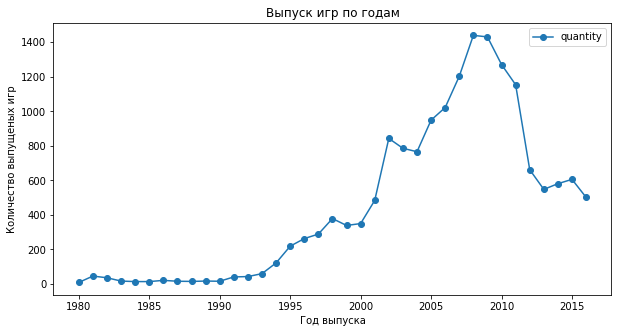

In [27]:
time_release = data.groupby('year_of_release')['name'].count().reset_index()
time_release.columns = ['year', 'quantity']
display (time_release)
time_release.plot('year', 'quantity', figsize=(10,5), style='o-')
plt.ylabel("Количество выпущеных игр") 
plt.xlabel("Год выпуска") 
plt.title ('Выпуск игр по годам')
plt.show()

До 1994 года в год выпускалось крайне мало игр. С 1994-го года начался значительный рост количества релизов (122 релиза за год), уже в этом году количесто релизов выросло в 2 раза по сравнению с предыдущими годами. Этот рост продлился до 2008-2009 годов (1440 и 1431 релизов), дальше небольшой спад до 2011 года. Начиная с 2012-го количество уменьшилось почти вдвое и осталось примерно на этом уровне до 2016 года. По-моему, в исследовании не важны данные за период с 1980 по 1993 год включительно, так как релизов в этот период крайне мало.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

,platform,total_sales
30,PS2,1255.77
29,X360,971.42
28,PS3,939.65
27,Wii,907.51
26,DS,806.12
25,PS,730.86
24,GBA,317.85
23,PS4,314.14
22,PSP,294.05
21,PC,259.52


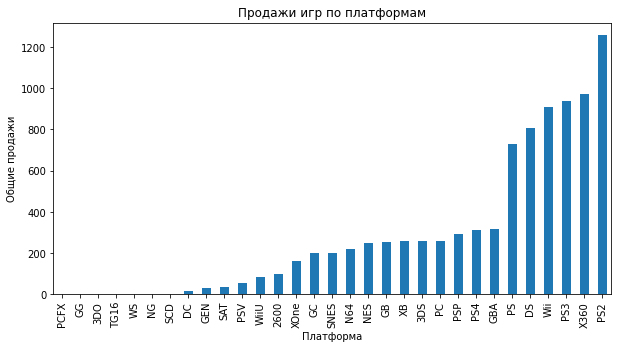

In [28]:
platform_sales = data.groupby('platform')['total_sales'].sum().sort_values().reset_index()
platform_sales.columns = ['platform', 'total_sales']
display (platform_sales.sort_values('total_sales', ascending=False))
platform_sales.plot('platform', 'total_sales', kind='bar', figsize=(10,5), legend=None)
plt.ylabel('Общие продажи') 
plt.xlabel('Платформа') 
plt.title ('Продажи игр по платформам')
plt.show()

По количеству продаж сильно выделяются 6 платформ. Посмотрим как менялись со временем продажи на этих платформах.

In [29]:
top_platform = platform_sales.loc[25:30, 'platform']
top_platform

25      PS
26      DS
27     Wii
28     PS3
29    X360
30     PS2
Name: platform, dtype: object

In [30]:
top_platform_sales = data.pivot_table(
    index=['platform', 'year_of_release'],
    values='total_sales', aggfunc='sum').reset_index()

top_platform_sales = top_platform_sales.query('platform in @top_platform')
top_platform_sales

,platform,year_of_release,total_sales
27,DS,1985,0.02
28,DS,2004,17.27
29,DS,2005,130.14
30,DS,2006,119.81
31,DS,2007,147.23
...,...,...,...
224,X360,2012,100.72
225,X360,2013,88.58
226,X360,2014,34.74
227,X360,2015,11.96


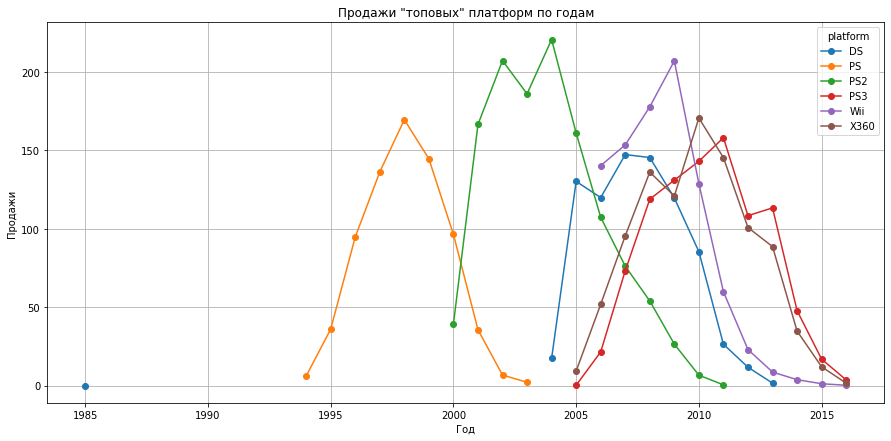

In [31]:
pivot_table = top_platform_sales.pivot_table(
    index='year_of_release', columns='platform',
    values='total_sales', aggfunc='sum')

pivot_table.plot(marker='o', figsize=(15,7))
plt.ylabel('Продажи') 
plt.xlabel('Год') 
plt.title ('Продажи "топовых" платформ по годам')
plt.grid(True)

In [32]:
data.loc[
    (data['year_of_release'] == 1985) &
    (data['platform'] == 'DS')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,<NA>,<NA>,NaN,0.02


По моему мнению, эту строку лучше вообще удалить из таблицы, так как данных в ней почти нет и платформа DS вышла в 2004 году. Из этого следует что тут есть какая-то ошибка.

In [33]:
pivot_table

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1985,0.02,NaN,NaN,NaN,NaN,NaN
1994,NaN,6.03,NaN,NaN,NaN,NaN
1995,NaN,35.96,NaN,NaN,NaN,NaN
1996,NaN,94.70,NaN,NaN,NaN,NaN
1997,NaN,136.17,NaN,NaN,NaN,NaN
1998,NaN,169.49,NaN,NaN,NaN,NaN
1999,NaN,144.53,NaN,NaN,NaN,NaN
2000,NaN,96.37,39.17,NaN,NaN,NaN
2001,NaN,35.59,166.43,NaN,NaN,NaN


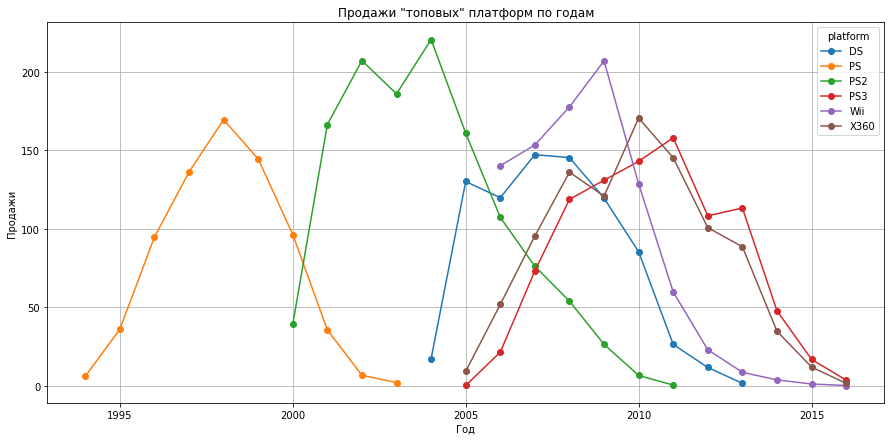

In [34]:
pivot_table.loc[1985,'DS'] = np.NaN

pivot_table.plot(marker='o', figsize=(15,7))

plt.ylabel('Продажи') 
plt.xlabel('Год') 
plt.title ('Продажи "топовых" платформ по годам')

plt.grid(True)
plt.show()

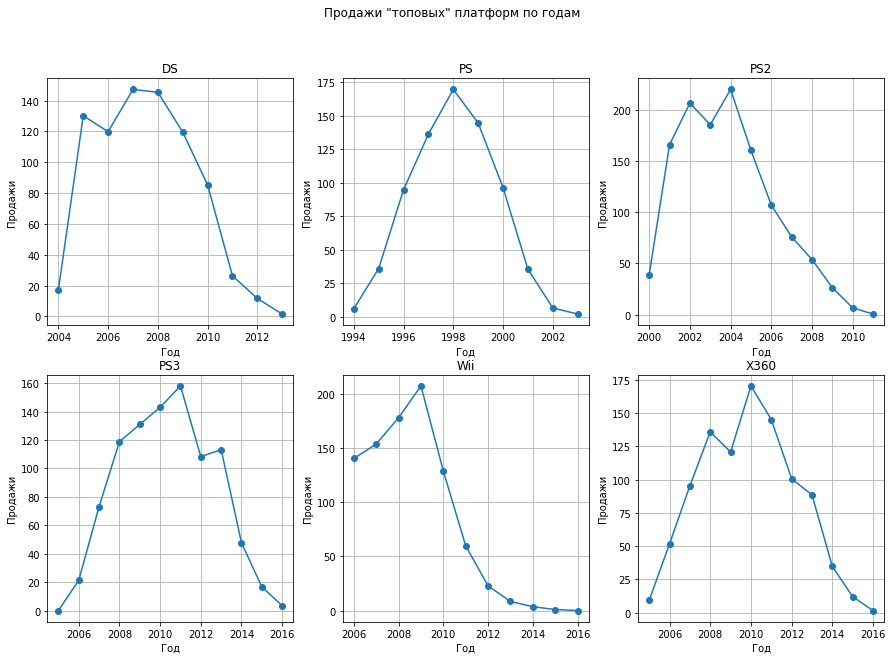

In [35]:
platforms = pivot_table.columns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.suptitle ('Продажи "топовых" платформ по годам')

for i, platform in enumerate(platforms):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(pivot_table.index, pivot_table[platform], marker='o')
    ax.set_ylabel('Продажи') 
    ax.set_xlabel('Год') 
    ax.set_title(platform)
    ax.grid(True)

plt.show()

На графике видно, что срок активного существования платформ примерно 10 лет, и распределение продаж идет близко к нормальному распределени. Не считая платформу Wii, на ней уже с запуска был высокий уровень продаж. Пик продаж у каждой платформы примерно в середине их времени существования. Топ-1 по продажам занимает платформа PS2 - 1255.77 миллионов копий за все время, затем X360 - 971.42 миллионов копий.

### Прогноз на 2017 год

**Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.**

В предыдущем пункте мы выяснили что примерный срок существования платформ - 10 лет. Нужно взять такой период, чтобы там были актуальные платформы на текущий момент. Потому что если взять +/- 10 лет, там буду платформы которые выходят из оборота, либо уже вышли. Поэтому думаю нужно взять интервал в 5 лет с 2012 по 2016 год. 

In [36]:
sales_pred = data.pivot_table(
    index='platform',
    columns='year_of_release',
    values='total_sales',
    aggfunc='sum')

sales_pred = sales_pred.loc[:,2012:2016].reset_index().fillna(0)
sales_pred = sales_pred[sales_pred.iloc[:, 1:].sum(axis=1) != 0].reset_index(drop=True)
sales_pred

year_of_release,platform,2012,2013,2014,2015,2016
0,3DS,51.76,56.57,43.76,27.78,15.14
1,DS,11.67,1.54,0.00,0.00,0.00
2,PC,23.45,13.01,13.28,8.52,5.25
3,PS3,108.28,113.25,47.76,16.82,3.60
4,PS4,0.00,25.99,100.00,118.90,69.25
5,PSP,7.95,3.38,0.24,0.12,0.00
6,PSV,16.19,10.59,11.90,6.25,4.25
7,Wii,22.94,8.59,3.75,1.14,0.18
8,WiiU,17.56,21.65,22.03,16.35,4.60
9,X360,100.72,88.58,34.74,11.96,1.52


Исключим из таблицы платформы, на которых закончились продажи к 2016-му году. И попробуем спрогнозировать продажи на 2017 год.

In [37]:
relevant_platform = ['3DS', 'PC', 'PS3', 'PS4', 'PSV', 'WiiU', 'X360', 'XOne']
sales_pred = sales_pred.query('platform in @relevant_platform')
sales_pred

year_of_release,platform,2012,2013,2014,2015,2016
0,3DS,51.76,56.57,43.76,27.78,15.14
2,PC,23.45,13.01,13.28,8.52,5.25
3,PS3,108.28,113.25,47.76,16.82,3.60
4,PS4,0.00,25.99,100.00,118.90,69.25
6,PSV,16.19,10.59,11.90,6.25,4.25
8,WiiU,17.56,21.65,22.03,16.35,4.60
9,X360,100.72,88.58,34.74,11.96,1.52
10,XOne,0.00,18.96,54.07,60.14,26.15


In [38]:
def forecast_sales(row):
    platform = row['platform']
    sales_data = row[2:].values
    model = ExponentialSmoothing(sales_data, trend='multiplicative', seasonal=None)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    row['2017'] = forecast[0]
    return row

sales_pred = sales_pred.apply(forecast_sales, axis=1)
display(sales_pred.round(2))

year_of_release,platform,2012,2013,2014,2015,2016,2017
0,3DS,51.76,56.57,43.76,27.78,15.14,12.64
2,PC,23.45,13.01,13.28,8.52,5.25,5.07
3,PS3,108.28,113.25,47.76,16.82,3.60,0.77
4,PS4,0.00,25.99,100.00,118.90,69.25,111.37
6,PSV,16.19,10.59,11.90,6.25,4.25,4.03
8,WiiU,17.56,21.65,22.03,16.35,4.60,1.29
9,X360,100.72,88.58,34.74,11.96,1.52,0.19
10,XOne,0.00,18.96,54.07,60.14,26.15,45.25


Результат прогнозирования в целом похож на потенциально возможный, но точности ждать не приходится, так как у нас нет всех данных за 2016 год. Но тенденцию в любом случае увидеть можно. Видно что на платформах 3DS, PS3, PSV и X360 продажи снижаются. На замену PS3 пришла платформа PS4, на ней продажи сильно выросли в 2014 году и дальше планомерно идут вверх, такая же ситуация с платформами X360 и XOne. На основе данных можно сделать вывод что ставку лучше сделать на платформы PS4 и XOne, они сейчас на стадии роста и лидируют по продажам в последние годы.

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

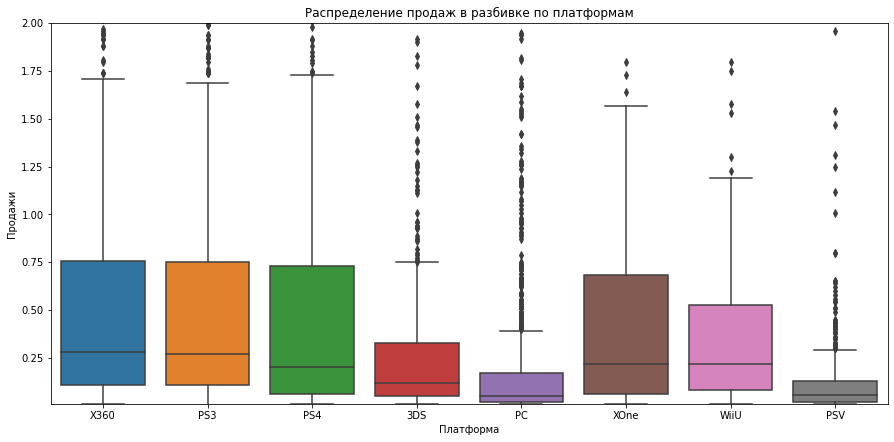

In [39]:
sales_data = data.query('platform in @relevant_platform')
plt.figure(figsize=(15,7))
sns.boxplot(data=sales_data, x='platform', y='total_sales')
plt.ylim(0.01,2)
plt.ylabel('Продажи') 
plt.xlabel('Платформа') 
plt.title ('Распределение продаж в разбивке по платформам')
plt.show()

Продажи на популярных платформах схожи. Медианные значения продаж у четырех платформ PS3, WiiU, X360, XOne находятся близко к уровню 0,2, а в других 4 к уровню 0,1. На платформах 3DS, PC, PSV большая часть проданых игр лежит до значения в 0.6, на платформах PS4, WiiU чуть больше 0.8, а в лидерах XOne и X360 до 1.1 и PS3 до 1.3 млн.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для выбора платформы для анализа возьмем наш ТОП-6 и посмотрим у какой платформы больше отзывов для более точного анализа.

In [40]:
display (data.groupby('platform')['user_score'].count().sort_values(ascending=False))

platform
PS2     1462
X360    1034
PS3      967
DS       854
PC       799
XB       743
Wii      740
PSP      539
GBA      500
GC       479
PS4      292
PS       240
3DS      218
XOne     207
PSV      170
WiiU     114
N64       23
DC        16
SNES      15
SAT        9
GB         4
2600       3
NES        3
GEN        3
WS         0
PCFX       0
TG16       0
3DO        0
GG         0
NG         0
SCD        0
Name: user_score, dtype: int64

Больше всего отзывов на платформе PS2. Посмотрим как на ней влияют отзывы пользователей и критиков на продажи.

In [41]:
PS2_df = data.query('platform=="PS2"')[
    ['total_sales', 'critic_score', 'user_score']].\
    dropna().reset_index(drop=True)
PS2_df.head()

,total_sales,critic_score,user_score
0,20.81,95,90
1,16.15,95,87
2,14.97,95,84
3,13.10,97,85
4,11.65,89,85


In [42]:
def single_plot(score,name):
    
    PS2_df.plot(x=score, y='total_sales',
            kind='scatter', figsize=(15,5), alpha=0.5)
    plt.title(f'Зависимость продаж от {name}')
    plt.ylabel('Продажи') 
    plt.xlabel(name) 
    plt.ylim(0,10)
    plt.show()

,total_sales,critic_score,user_score
total_sales,1.000000,0.379181,0.206182
critic_score,0.379181,1.000000,0.607540
user_score,0.206182,0.607540,1.000000


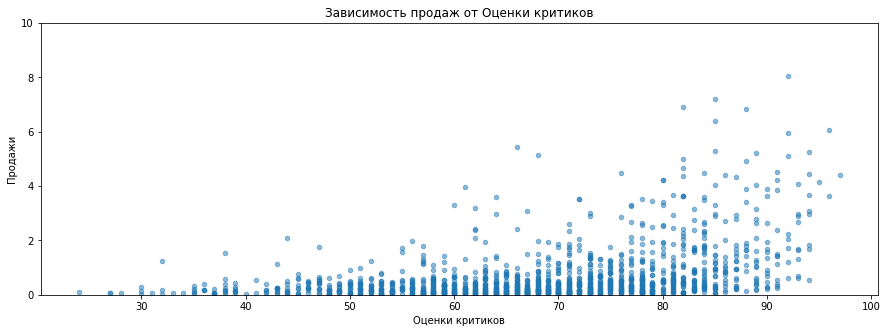

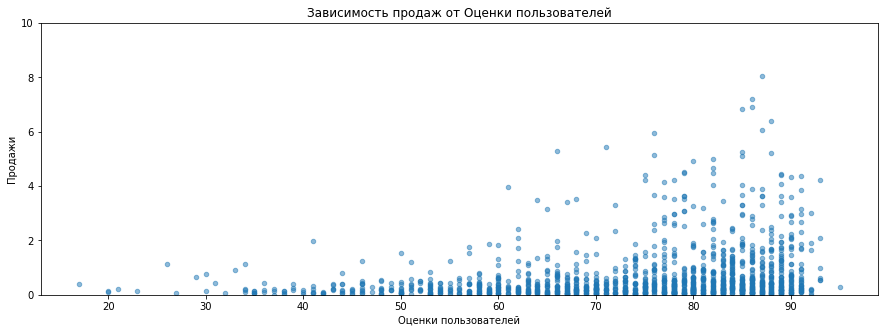

In [43]:
display (PS2_df.corr())
single_plot('critic_score', 'Оценки критиков')
single_plot('user_score', 'Оценки пользователей')

По платформе PS2:

Отзывы критиков важны, зависимость продаж от них находится на уровне выше среднего (коэффициент 0,61); зависимость здесь прямопропорцианальная - чем выше оценка, тем выше продажи. И зависимость продаж от отзывов пользователей, как выясняется слабая, но ближе к средней, также она прямопропорцианальная(хотя коэффициент значительно меньше - 0,21). В общем зависимости схожи.

### Соотнесите выводы из пункта 3.6 с продажами игр на других платформах.

In [44]:
top6 = data[['platform', 'total_sales',
                  'critic_score', 'user_score']
                ].dropna().reset_index(drop=True)
top6 = top6.query('platform in @top_platform')
top6.head()

,platform,total_sales,critic_score,user_score
0,Wii,82.54,76,80
1,Wii,35.52,82,83
2,Wii,32.77,80,80
3,DS,29.80,89,85
4,Wii,28.91,58,66


In [45]:
def multiple_plot(score,name):
    
    plt.figure(figsize=(15,10))
    sns.scatterplot(data=top6, x=score, y='total_sales', hue='platform', alpha=0.5)
    plt.ylim(0,10)
    plt.title(f'Зависимость продаж от {name} на разных платформах')
    plt.ylabel('Продажи') 
    plt.xlabel(name) 
    plt.show()

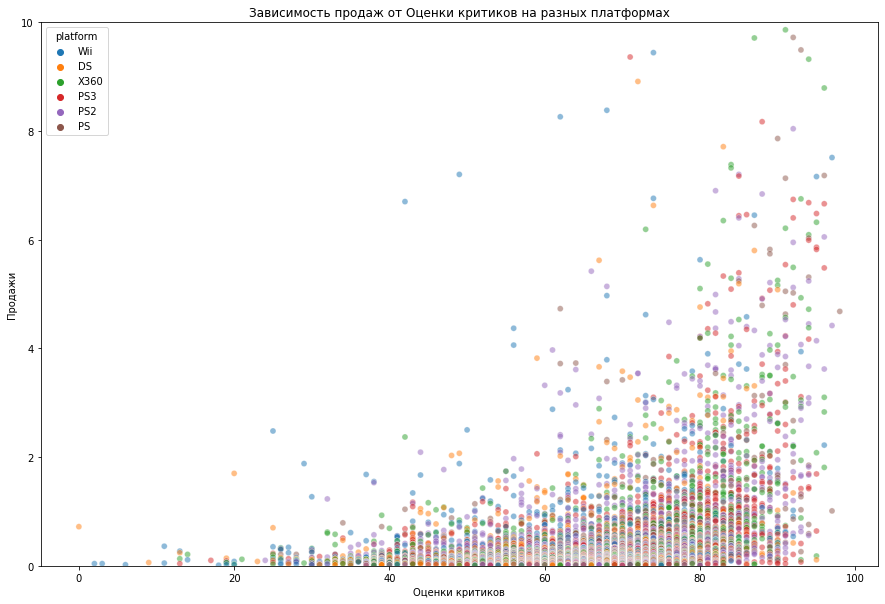

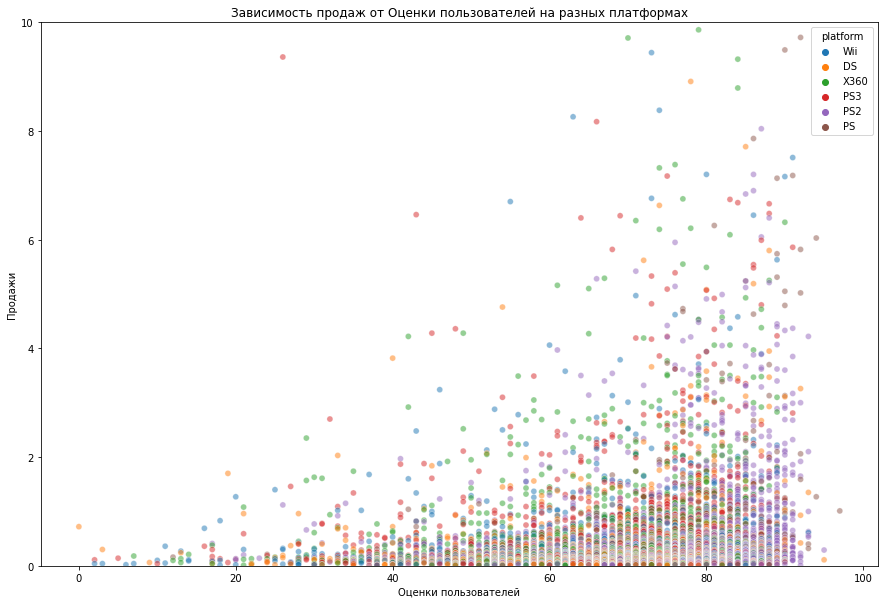

In [46]:
multiple_plot('critic_score', 'Оценки критиков')
multiple_plot('user_score', 'Оценки пользователей')

In [47]:
score_df = data.query('platform in @top_platform')[
    ['total_sales', 'critic_score', 'user_score']].\
    dropna().reset_index(drop=True)
display (PS2_df.corr())
score_df.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.379181,0.206182
critic_score,0.379181,1.000000,0.607540
user_score,0.206182,0.607540,1.000000


,total_sales,critic_score,user_score
total_sales,1.000000,0.265195,0.136212
critic_score,0.265195,1.000000,0.652311
user_score,0.136212,0.652311,1.000000


Общая тенденция в целом схожая с зависимостями по платформе PS2. Для топовых платформ, в целом, зависимости слабее. Оценки критиков так же больше влияют на продажи, чем оценки пользователей.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

genre
Action          1744.17
Sports          1331.27
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: total_sales, dtype: float64

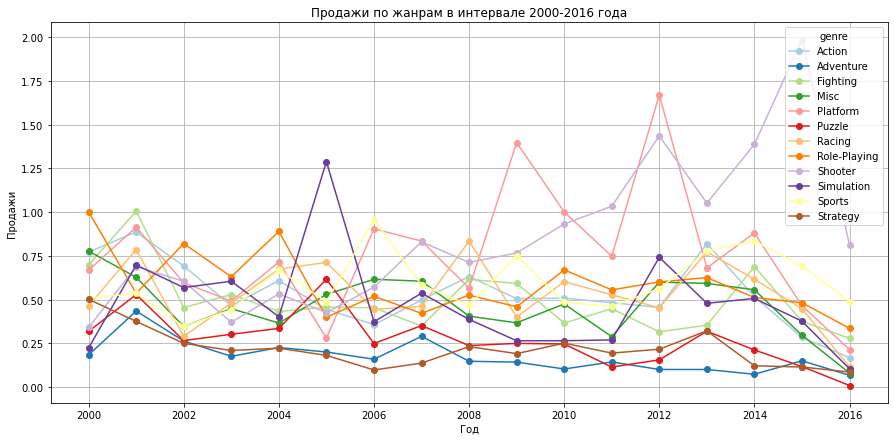

In [48]:
genre_sales = data.pivot_table(
    index='year_of_release', columns='genre',
    values='total_sales', aggfunc='mean').fillna(0).query('year_of_release >= 2000')

genre_total = data.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
display(genre_total)

genre_sales.plot(marker='o', figsize=(15,7), colormap='Paired')

plt.ylabel('Продажи') 
plt.xlabel('Год') 
plt.title ('Продажи по жанрам в интервале 2000-2016 года')

plt.grid(True)
plt.show()

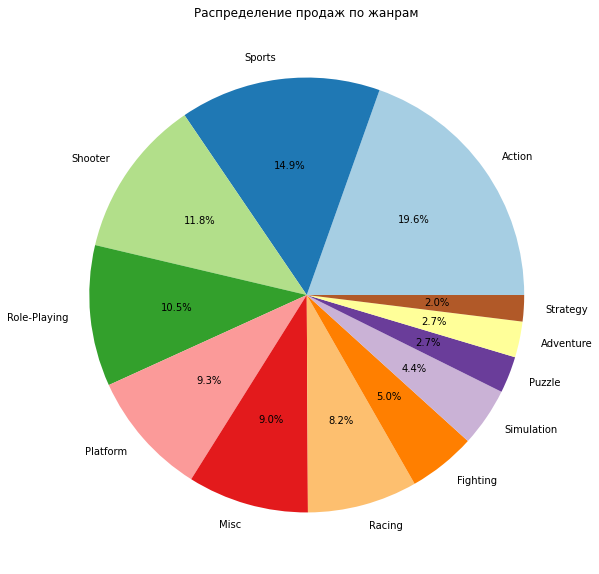

In [49]:
genre_total.plot(
    kind='pie', subplots=True, figsize=(10, 10),
    autopct='%1.1f%%', colormap='Paired')
plt.title('Распределение продаж по жанрам')
plt.ylabel("")
plt.show()

Больше всего продаются игры жанра Action, продажи почти на всем интервале выше конкурентов, в 2006 году этот жанр опередил Sports. За все время большую долю в продажах занимают жанры Action (19.6%) и Sports (14.9%). В худшую сторону выделяются 3 жанра с очень низкой долей продаж: 
- Puzzle - 2.7%
- Adventure - 2.7%
- Strategy - 2.0%

Популярность жанра Simulation выросла с 2005 по 2008 год, видимо были какие-то интересные проекты, дальше плавный спад до конца исследуемого периода. Жанр Misc так же довольно быстро вырос в популярности с 2004 по 2010 год, затем так же быстро "скатился" до уровня 2003 года.

### Вывод

До 1994 года в год выпускалось крайне мало игр. С 1994-го года начался значительный рост количества релизов (122 релиза за год), уже в этом году количесто релизов выросло в 2 раза по сравнению с предыдущими годами. Этот рост продлился до 2008-2009 годов (1440 и 1431 релизов), дальше небольшой спад до 2011 года. Начиная с 2012-го количество уменьшилось почти вдвое и осталось примерно на этом уровне до 2016 года.

Срок активного существования платформ примерно 10 лет, и распределение продаж идет близко к нормальному распределени. Не считая платформу Wii, на ней уже с запуска был высокий уровень продаж. Пик продаж у каждой платформы примерно в середине их времени существования. Топ-1 по продажам занимает платформа PS2 - 1255.77 миллионов копий за все время, затем X360 - 971.42 миллионов копий.

С учетом неполных данных за 2016 год сделали вывод что на платформах 3DS, PS3, PSV и X360 продажи снижаются. На замену PS3 пришла платформа PS4, на ней продажи сильно выросли в 2014 году и дальше планомерно идут вверх, такая же ситуация с платформами X360 и XOne. На основе данных можно сделать вывод что ставку лучше сделать на платформы PS4 и XOne, они сейчас на стадии роста и лидируют по продажам в последние годы.

Продажи на популярных платформах схожи. Медианные значения продаж у четырех платформ PS3, WiiU, X360, XOne находятся близко к уровню 0,2, а в других 4 к уровню 0,1. На платформах 3DS, PC, PSV большая часть проданых игр лежит до значения в 0.6, на платформах PS4, WiiU чуть больше 0.8, а в лидерах XOne и X360 до 1.1 и PS3 до 1.3 млн.

По платформе PS2: Отзывы критиков важны, зависимость продаж от них находится на уровне выше среднего (коэффициент 0,61); зависимость здесь прямопропорцианальная - чем выше оценка, тем выше продажи. И зависимость продаж от отзывов пользователей, как выясняется слабая, но ближе к средней, также она прямопропорцианальная(хотя коэффициент значительно меньше - 0,21). В общем зависимости схожи.

Общая тенденция в целом схожая с зависимостями по платформе PS2. Для топовых платформ, в целом, зависимости слабее. Оценки критиков так же больше влияют на продажи, чем оценки пользователей.

Больше всего продаются игры жанра Action, продажи почти на всем интервале выше конкурентов, в 2006 году этот жанр опередил Sports. За все время большую долю в продажах занимают жанры Action (19.6%) и Sports (14.9%). В худшую сторону выделяются 3 жанра с очень низкой долей продаж: 
- Puzzle - 2.7%
- Adventure - 2.7%
- Strategy - 2.0%

Популярность жанра Simulation выросла с 2005 по 2008 год, видимо были какие-то интересные проекты, дальше плавный спад до конца исследуемого периода. Жанр Misc так же довольно быстро вырос в популярности с 2004 по 2010 год, затем так же быстро "скатился" до уровня 2003 года.

## Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Самые популярные платформы (топ-5). Опишите различия в долях продаж

In [50]:
top_platforms_by_region = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    
    top_platforms_by_region[region] = data.\
    groupby('platform')[region].sum().\
    sort_values(ascending=False).head(5)
    
top_platforms_by_region

{'na_sales': platform
 X360    602.47
 PS2     583.84
 Wii     496.90
 PS3     393.49
 DS      382.40
 Name: na_sales, dtype: float64,
 'eu_sales': platform
 PS2     339.29
 PS3     330.29
 X360    270.76
 Wii     262.21
 PS      213.61
 Name: eu_sales, dtype: float64,
 'jp_sales': platform
 DS      175.57
 PS      139.82
 PS2     139.20
 SNES    116.55
 3DS     100.67
 Name: jp_sales, dtype: float64}

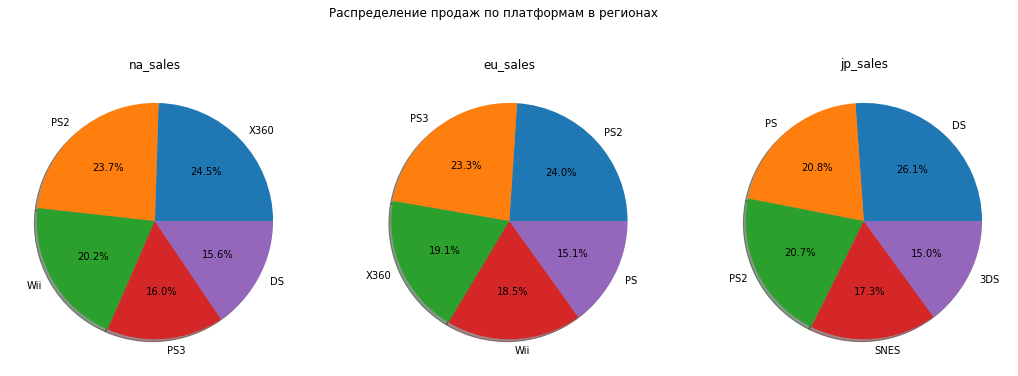

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in [0,1,2]:
    labels = top_platforms_by_region[region[i]].index
    sizes = top_platforms_by_region[region[i]].values
    ax = x[i]
    ax.set_title(region[i])
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) 

plt.suptitle('Распределение продаж по платформам в регионах', y=0.8)
plt.show()

Во всех регионах ТОП-5 платформ отличается. Во всех регионах есть платформа PS2, но с разной долей продаж: NA - 23.7%, EU - 24%, JP - 20.7%. В Северной Америке и Европе доля практически одинаковая, в Японии ниже на 3%. В NA на первом месте X360 (24.5%), PS2 - на втором месте, но разница между ними всего 0.8%. В Европе на первом месте PS2 (24%) и PS3 (23.3%) - на втором, тоже разница совсем небольшая. В Японии больше любят платформу DS (26.1%), второе (PS) и третье (PS2) место остаются уже заметнее, чуть больше чем на 5%.

### Самые популярные жанры (топ-5). Поясните разницу.

In [52]:
top_genre_by_region = {}
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    
    top_genre_by_region[region] = data.\
    groupby('genre')[region].sum().\
    sort_values(ascending=False).head(5)
    
top_genre_by_region

{'na_sales': genre
 Action      879.01
 Sports      684.43
 Shooter     592.24
 Platform    445.50
 Misc        407.27
 Name: na_sales, dtype: float64,
 'eu_sales': genre
 Action     519.13
 Sports     376.79
 Shooter    317.34
 Racing     236.51
 Misc       212.74
 Name: eu_sales, dtype: float64,
 'jp_sales': genre
 Role-Playing    355.41
 Action          161.43
 Sports          135.54
 Platform        130.83
 Misc            108.11
 Name: jp_sales, dtype: float64}

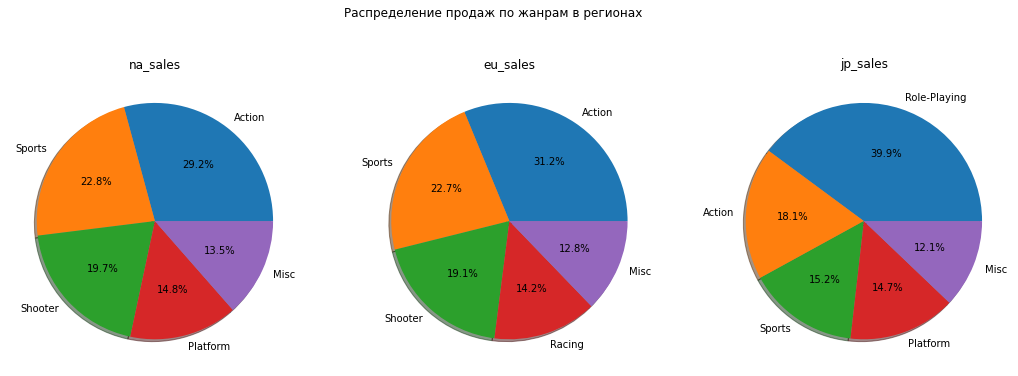

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in [0,1,2]:
    labels = top_genre_by_region[region[i]].index
    sizes = top_genre_by_region[region[i]].values
    ax = x[i]
    ax.set_title(region[i])
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

plt.suptitle('Распределение продаж по жанрам в регионах', y=0.8)
plt.show()

Популярные жанры в Северной Америке и Европе практически идентичные как по соотношению, так и по самим жанрам. Отличается только четвертое место: в Северной Америке это Platform, а в Европе - Racing. В обоих регионах доминирует жанр Action (29.2% и 31.2%). Дальше Sports и Shooter (22 и 19 процентов, с совсем небольшим отличием по регионам). В Японии топ-3 из других регионов сместил Role-Playing (почти 40%), дальше Action (18.1%), Sports (15.2%) и Platform (14.7%). Во всех регионах топ-5 закрывает жанр Misc (12.1 - 13.5%)

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [54]:
esrb_sales = data.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().reset_index()
esrb_sales

,rating,na_sales,eu_sales,jp_sales
0,AO,1.26,0.61,0.00
1,E,1343.73,734.00,211.82
2,E10+,364.95,195.31,51.45
3,EC,2.04,0.11,0.00
4,K-A,2.59,0.29,1.49
5,M,768.16,501.68,68.42
6,RP,0.00,0.08,0.00
7,T,785.44,444.82,160.20


Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.

- «E» («Everyone») — Для всех
- «T» («Teen») — Подросткам
- «M» («Mature») — Для взрослых
- «E10+» («Everyone 10 and older») — Для всех от 10 лет и старше
- «EC»(«K-A» - в ранних версиях с 1994-1997 годы) («Early childhood») — Для детей младшего возраста
- «AO» («Adults Only 18+») — Только для взрослых
- «RP» («Rating Pending») — Рейтинг ожидается

Видно что есть четыре основных рейтинга: E, E10+, M и Т. По остальным почти нет продаж, их рассматривать не будем. 

In [55]:
other = ['AO', 'EC', 'K-A', 'RP']
other_row = esrb_sales[esrb_sales['rating'].isin(other)].sum()
other_row['rating'] = 'Other'
esrb_sales = esrb_sales.append(other_row, ignore_index=True)
esrb_sales = esrb_sales[~esrb_sales['rating'].isin(other)].reset_index(drop=True)
esrb_sales

,rating,na_sales,eu_sales,jp_sales
0,E,1343.73,734.00,211.82
1,E10+,364.95,195.31,51.45
2,M,768.16,501.68,68.42
3,T,785.44,444.82,160.20
4,Other,5.89,1.09,1.49


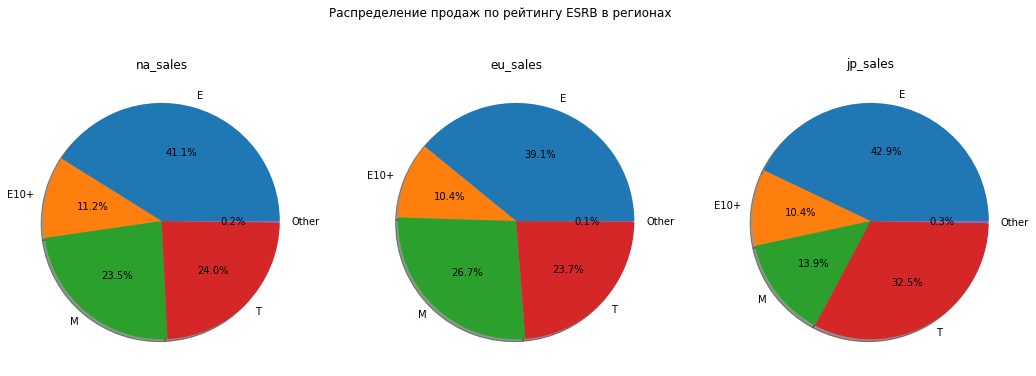

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))

i = 0
x = [ax1, ax2, ax3]
region = ['na_sales', 'eu_sales', 'jp_sales']

for i in [0,1,2]:
    labels = esrb_sales['rating']
    sizes = esrb_sales[region[i]].values
    ax = x[i]
    ax.set_title(region[i])
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) 
    
plt.suptitle('Распределение продаж по рейтингу ESRB в регионах', y=0.8)
plt.show()

Во всех регионах большую долю продаж занимают игры с рейтингом E (39.1 - 42.9%), категория E10+ почти одинаковую долю во всех регионах (10.4 - 11.2%). В Северной Америке и Европе практически одинаковые доли у категорий M и T. В Японии продаж с рейтингом T сильно больше, чем M, почти на 19%.

### Вывод

Во всех регионах ТОП-5 платформ отличается. Во всех регионах есть платформа PS2, но с разной долей продаж: NA - 23.7%, EU - 24%, JP - 20.7%. В Северной Америке и Европе доля практически одинаковая, в Японии ниже на 3%. В NA на первом месте X360 (24.5%), PS2 - на втором месте, но разница между ними всего 0.8%. В Европе на первом месте PS2 (24%) и PS3 (23.3%) - на втором, тоже разница совсем небольшая. В Японии больше любят платформу DS (26.1%), второе (PS) и третье (PS2) место остаются уже заметнее, чуть больше чем на 5%.

Популярные жанры в Северной Америке и Европе практически идентичные как по соотношению, так и по самим жанрам. Отличается только четвертое место: в Северной Америке это Platform, а в Европе - Racing. В обоих регионах доминирует жанр Action (29.2% и 31.2%). Дальше Sports и Shooter (22 и 19 процентов, с совсем небольшим отличием по регионам). В Японии топ-3 из других регионов сместил Role-Playing (почти 40%), дальше Action (18.1%), Sports (15.2%) и Platform (14.7%). Во всех регионах топ-5 закрывает жанр Misc (12.1 - 13.5%)

Во всех регионах большую долю продаж занимают игры с рейтингом E (39.1 - 42.9%), категория E10+ почти одинаковую долю во всех регионах (10.4 - 11.2%). В Северной Америке и Европе практически одинаковые доли у категорий M и T. В Японии продаж с рейтингом T сильно больше, чем M, почти на 19%.

## Проверьте гипотезы

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Задайте самостоятельно пороговое значение alpha.

Поясните:
- Как вы сформулировали нулевую и альтернативную гипотезы;
- Какой критерий применили для проверки гипотез и почему.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

**Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC равны

**Альтернативная гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [57]:
def stat_test(way, name1, name2): 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    graph_data = data[data[way] == name1]
    axes[0].hist(graph_data['user_score'].dropna(), bins=10)
    axes[0].set_title(f'Распределение оценок пользователей на {name1}')
    axes[0].set_xlabel('Оценки пользователей')
    axes[0].set_ylabel('Частота')
    
    graph_data = data[data[way] == name2]
    axes[1].hist(graph_data['user_score'].dropna(), bins=10)
    axes[1].set_title(f'Распределение оценок пользователей на {name2}')
    axes[1].set_xlabel('Оценки пользователей')
    axes[1].set_ylabel('Частота')
    plt.show()
    
    rating1 = data.loc[data[way] == name1, 'user_score'].dropna().to_list()
    print(f'Количество оценок {name1}', len(rating1))
    rating2 = data.loc[data[way] == name2, 'user_score'].dropna().to_list()
    print(f'Количество оценок {name2}', len(rating2))
    print()
    
    
    alpha = 0.05
    
    results = st.ttest_ind(rating1, rating2, equal_var=False)
    print('p-значение:', results.pvalue)
    print()
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

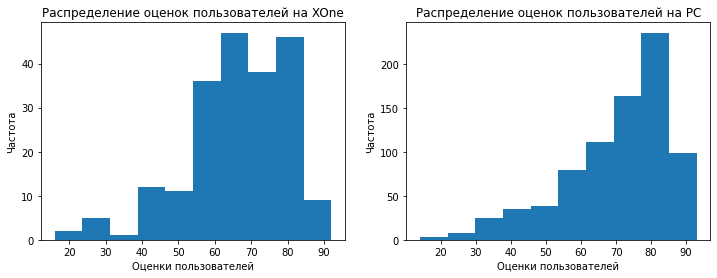

Количество оценок XOne 207
Количество оценок PC 799

p-значение: 4.809249693182703e-05

Отвергаем нулевую гипотезу


In [58]:
stat_test('platform', 'XOne', 'PC')

Нулевая гипотеза отвергнута, это говорит о том что пользовательские оценки на платформах Xbox One и PC отличаются.

### Средние пользовательские рейтинги жанров Action и Sports разные.

**Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action и Sports равны

**Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action и Sports отличаются

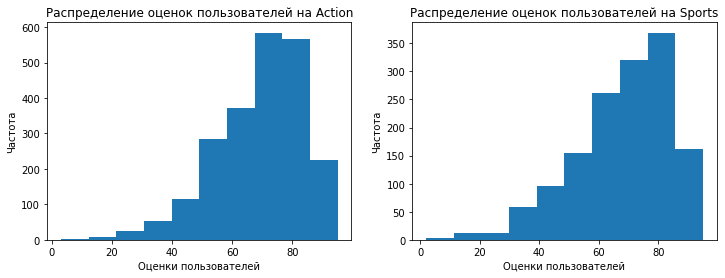

Количество оценок Action 2232
Количество оценок Sports 1449

p-значение: 0.05714797917968635

Не получилось отвергнуть нулевую гипотезу


In [59]:
stat_test('genre', 'Action', 'Sports')

Не получилось отвергнуть нулевую гипотезу, это говорит о том что средние рейтинги жанров Action и Sports одинаковые.

### Вывод

В результате проверки гипотезы о том что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, выяснили что рейтинги отличаются.

В результате проверки гипотезы о том что средние пользовательские рейтинги жанров Action и Sports одинаковые, выяснили что рейтинги одинаковые.

## Общий вывод

На этапе предобработки были выполнены следующие действия:

- Переименовали все столбцы, чтобы привести название к нижнему регистру
- Удалили 2 строки, так как были пропуски в столбцах name и genre
- В столбце year_of_release заполнили 130 пропусков значениями для этой же игры, но с другой платформы. Осталось 139 пропусков, но логического наполнения для них нет.
- В столбце user_score cократили количество пропусков на 1844, с учетом значений tbd (которые мы заменили на NaN). Часть пропусков заполнили оценкой этой же игры с другой платформы, часть значениями из critic_score. Умножили значения на 10, для того чтобы оценки пользователей и критиков были в одном формате.
- В столбце critic_score cократили количество пропусков на 1297 по аналогии со столбцом user_score. Только изменили порядок действий. Сначала использовали данные из этого столбца, потом, где было возможно, заполнили оценками пользователей.
- Добавили новый столбец total_sales с суммарными продажами каждой игры по всем регионам.
- Изменили тип данных столбцов year_of_release, critic_score и user_score c float на integer, в них были записаны целые числа, но с нулевой десятичной частью.

На этапе исследовательского анализа сделали следующие выводы:
- До 1994 года в год выпускалось крайне мало игр. С 1994-го года начался значительный рост количества релизов (122 релиза за год), уже в этом году количесто релизов выросло в 2 раза по сравнению с предыдущими годами. Этот рост продлился до 2008-2009 годов (1440 и 1431 релизов), дальше небольшой спад до 2011 года. Начиная с 2012-го количество уменьшилось почти вдвое и осталось примерно на этом уровне до 2016 года.
- Срок активного существования платформ примерно 10 лет, и распределение продаж идет близко к нормальному распределени. Не считая платформу Wii, на ней уже с запуска был высокий уровень продаж. Пик продаж у каждой платформы примерно в середине их времени существования. Топ-1 по продажам занимает платформа PS2 - 1255.77 миллионов копий за все время, затем X360 - 971.42 миллионов копий.
- С учетом неполных данных за 2016 год сделали вывод что на платформах 3DS, PS3, PSV и X360 продажи снижаются. На замену PS3 пришла платформа PS4, на ней продажи сильно выросли в 2014 году и дальше планомерно идут вверх, такая же ситуация с платформами X360 и XOne. На основе данных можно сделать вывод что ставку лучше сделать на платформы PS4 и XOne, они сейчас на стадии роста и лидируют по продажам в последние годы.
- Продажи на популярных платформах схожи. Медианные значения продаж у четырех платформ PS3, WiiU, X360, XOne находятся близко к уровню 0,2, а в других 4 к уровню 0,1. На платформах 3DS, PC, PSV большая часть проданых игр лежит до значения в 0.6, на платформах PS4, WiiU чуть больше 0.8, а в лидерах XOne и X360 до 1.1 и PS3 до 1.3 млн.
- По платформе PS2: Отзывы критиков важны, зависимость продаж от них находится на уровне выше среднего (коэффициент 0,61); зависимость здесь прямопропорцианальная - чем выше оценка, тем выше продажи. И зависимость продаж от отзывов пользователей, как выясняется слабая, но ближе к средней, также она прямопропорцианальная(хотя коэффициент значительно меньше - 0,21). В общем зависимости схожи. Общая тенденция в целом схожая с зависимостями по платформе PS2. Для топовых платформ, в целом, зависимости слабее. Оценки критиков так же больше влияют на продажи, чем оценки пользователей.
- Больше всего продаются игры жанра Action, продажи почти на всем интервале выше конкурентов, в 2006 году этот жанр опередил Sports. За все время большую долю в продажах занимают жанры Action (19.6%) и Sports (14.9%). В худшую сторону выделяются 3 жанра с очень низкой долей продаж: Puzzle - 2.7%, Adventure - 2.7%, Strategy - 2.0%. Популярность жанра Simulation выросла с 2005 по 2008 год, видимо были какие-то интересные проекты, дальше плавный спад до конца исследуемого периода. Жанр Misc так же довольно быстро вырос в популярности с 2004 по 2010 год, затем так же быстро "скатился" до уровня 2003 года.


Дальше изучили по регионам топ-5 жанров и платформ, так же рейтинг ESRB. Сделали следующие выводы:

- Во всех регионах ТОП-5 платформ отличается. Во всех регионах есть платформа PS2, но с разной долей продаж: NA - 23.7%, EU - 24%, JP - 20.7%. В Северной Америке и Европе доля практически одинаковая, в Японии ниже на 3%. В NA на первом месте X360 (24.5%), PS2 - на втором месте, но разница между ними всего 0.8%. В Европе на первом месте PS2 (24%) и PS3 (23.3%) - на втором, тоже разница совсем небольшая. В Японии больше любят платформу DS (26.1%), второе (PS) и третье (PS2) место остаются уже заметнее, чуть больше чем на 5%.
- Популярные жанры в Северной Америке и Европе практически идентичные как по соотношению, так и по самим жанрам. Отличается только четвертое место: в Северной Америке это Platform, а в Европе - Racing. В обоих регионах доминирует жанр Action (29.2% и 31.2%). Дальше Sports и Shooter (22 и 19 процентов, с совсем небольшим отличием по регионам). В Японии топ-3 из других регионов сместил Role-Playing (почти 40%), дальше Action (18.1%), Sports (15.2%) и Platform (14.7%). Во всех регионах топ-5 закрывает жанр Misc (12.1 - 13.5%)
- Во всех регионах большую долю продаж занимают игры с рейтингом E (39.1 - 42.9%), категория E10+ почти одинаковую долю во всех регионах (10.4 - 11.2%). В Северной Америке и Европе практически одинаковые доли у категорий M и T. В Японии продаж с рейтингом T сильно больше, чем M, почти на 19%.

Проверили две гипотезы:
- В результате проверки гипотезы о том что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, выяснили что рейтинги отличаются.
- В результате проверки гипотезы о том что средние пользовательские рейтинги жанров Action и Sports одинаковые, выяснили что рейтинги одинаковые.